# Expectancy

Based on:

- [https://www.learningmarkets.com/determining-expectancy-in-your-trading/](https://www.learningmarkets.com/determining-expectancy-in-your-trading/)
- [http://www.unicorn.us.com/trading/expectancy.html](http://www.unicorn.us.com/trading/expectancy.html)

In [1]:
source("JupyterUtils.R")
source("C2ScoreHypothesisPresentation.R")

     Systems    Obsrvtns     Minimum     1st Qu.      Median        Mean     3rd Qu.     Maximum          SD 
        2424      649678     -0.9478      0.3871      0.7656      2.6524      1.4396   7455.0000     47.7684 


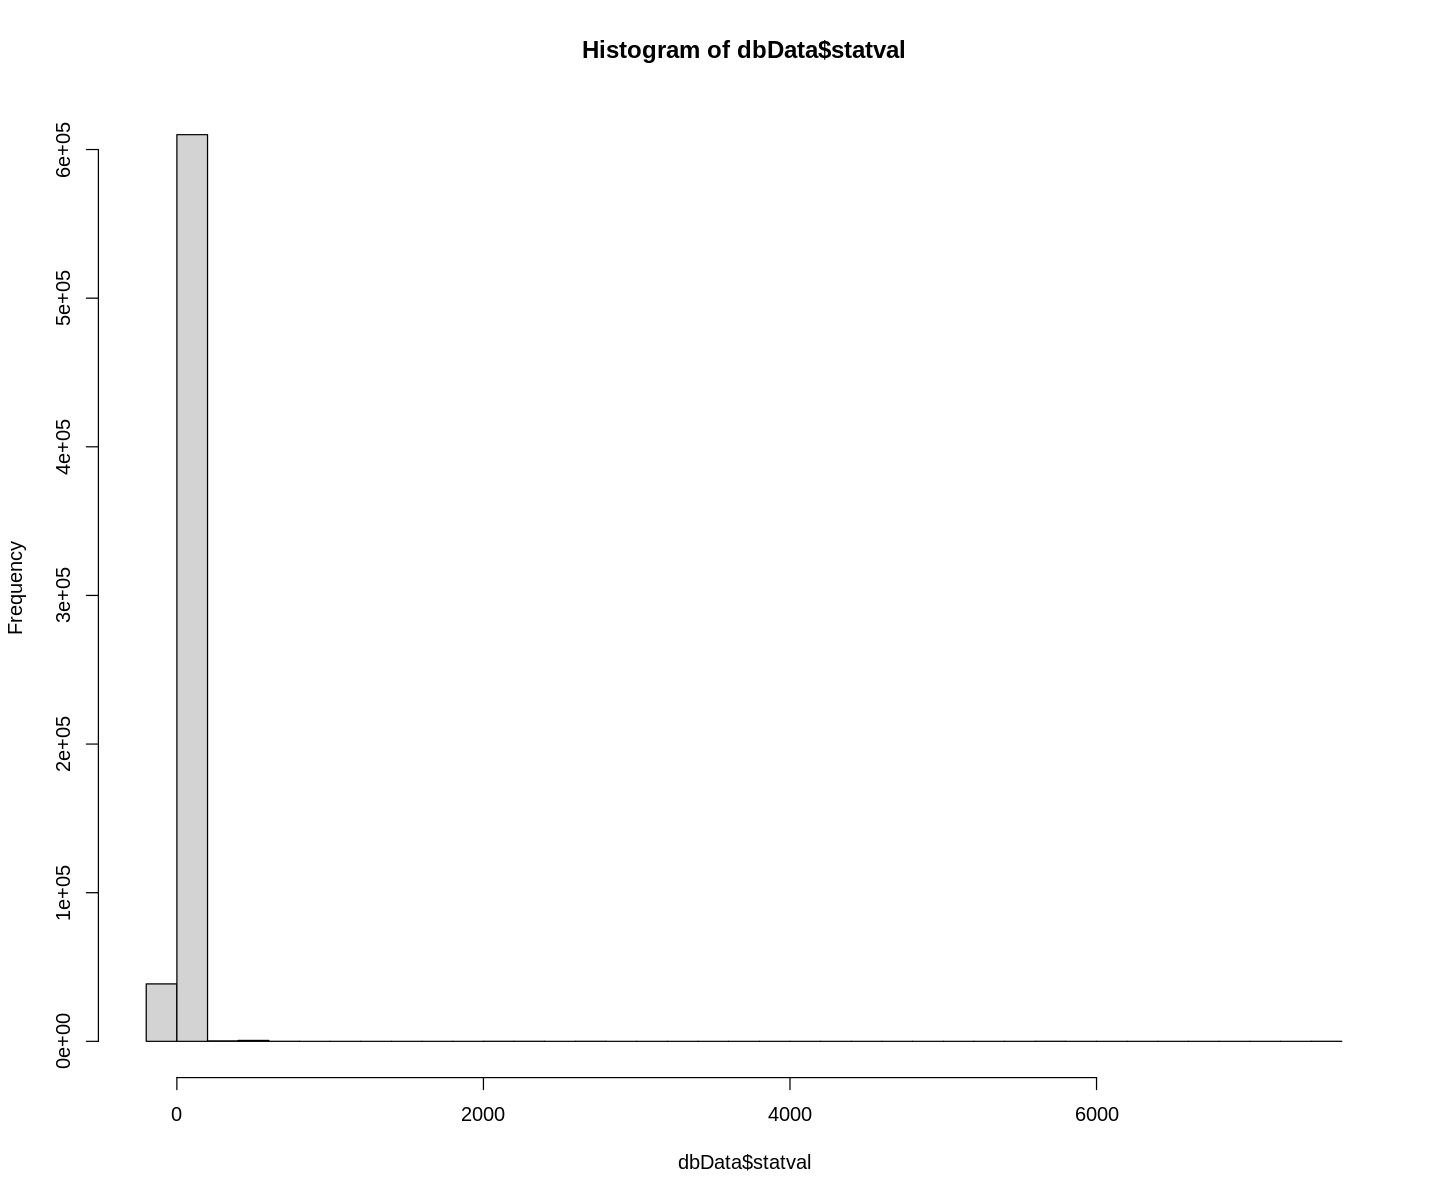

In [16]:
# What data we have.
sql = "SELECT
 systemid, 
 datestart as date, 
 ((AvgWin / AvgLoss) - (cast(numloss as float) / numtrades)) as statval
 FROM (
        SELECT 
            r.systemid,	
            r.datestart,
            ( SELECT count(*)
                  FROM c2ex_trades
                  WHERE systemid = r.systemid 
                  AND date(exittime) <= r.datestart) AS numtrades,
            ( SELECT count(*)
                  FROM c2ex_trades
                  WHERE systemid = r.systemid 
                  AND date(exittime) <= r.datestart
                  AND result <= 0) AS numloss,
            ( SELECT avg(result)
                  FROM c2ex_trades
                  WHERE systemid = r.systemid 
                  AND date(exittime) <= r.datestart
                  AND result > 0 ) AS avgwin,
            ( SELECT abs(avg(result))
                  FROM c2ex_trades
                  WHERE systemid = r.systemid 
                  AND date(exittime) <= r.datestart
                  AND result <= 0 ) AS avgloss
           FROM returnsdatainintervalscleanedskip090 r
           JOIN c2ex_results res ON res.systemid = r.systemid
           ) sub
  WHERE 
    numtrades > 0 -- divider 
    and avgloss > 0 -- divider"

# The above query is stored in the database as the materialized view ExpectancyView.
sql = "select * from expectancyView where statval is not null order by 1,2;"
dbData = getC2ScoreDbData(sql)
overview(dbData)
hist(dbData$statval,breaks=50)

     Systems    Obsrvtns     Minimum     1st Qu.      Median        Mean     3rd Qu.     Maximum          SD 
        2208      517616      0.2500      0.5474      0.8758      1.1540      1.4853      5.0000      0.8612 


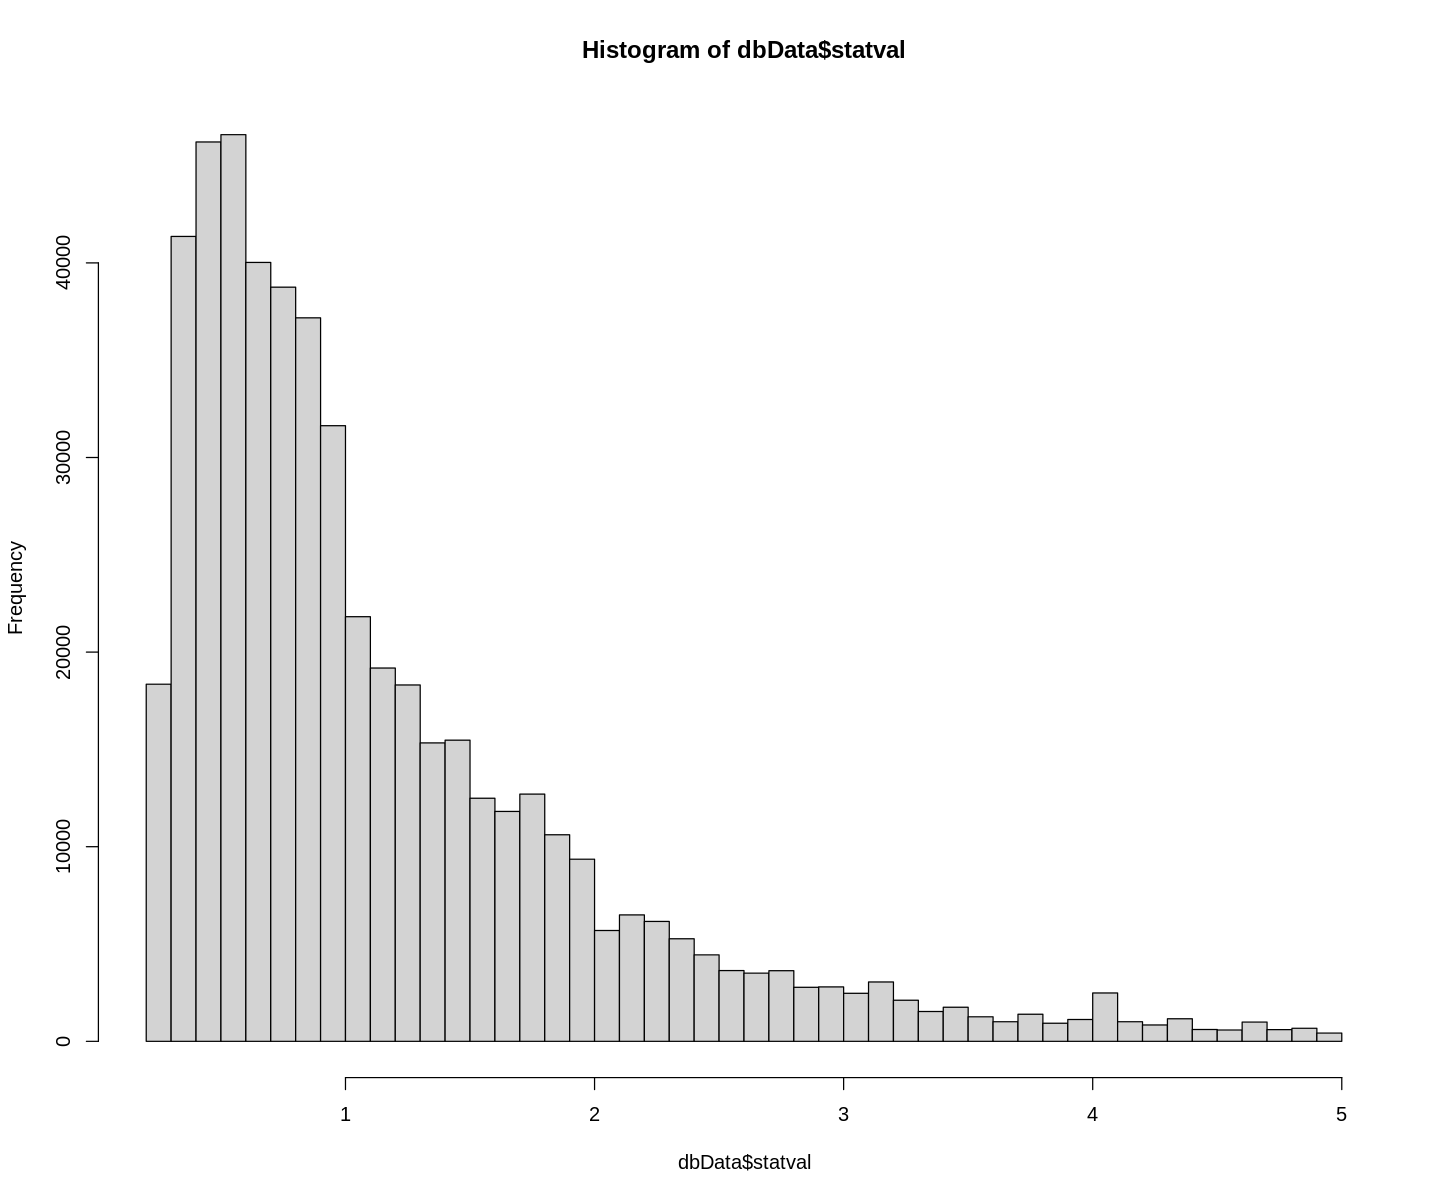

In [10]:
# Let's get expectancy 0.25 - 5.0
sql = "select * 
        from ReturnsDataInIntervalsCleanedSkip090 r
        join expectancyView e on e.systemid=r.systemid and e.date = r.datestart
        where 
          statval is not null 
          and statval >= 0.25 
          and statval <= 5.0 
          order by 1,2;"

dbData = getC2ScoreDbData(sql)
overview(dbData)
hist(dbData$statval,breaks=50)



We have calculated and stored the whole population statistics of strategies daily returns after 7, 14, ..., 360 days. Day after day. Now, we selected a particular statistics data (a sample) from the whole population. We want to know, if the average of returns of the sample is significantly higher than an average of returns of the whole population. A significance level is  0.05 .

The following table contains this hypothesis tests for defined stats intervals and all 7, 14, ..., 360 days time intervals.


Descriptive stats of all data selected in the experiment:
     Systems    Obsrvtns     Minimum     1st Qu.      Median        Mean     3rd Qu.     Maximum          SD 
        2208      517616      0.2500      0.5474      0.8758      1.1540      1.4853      5.0000      0.8612 



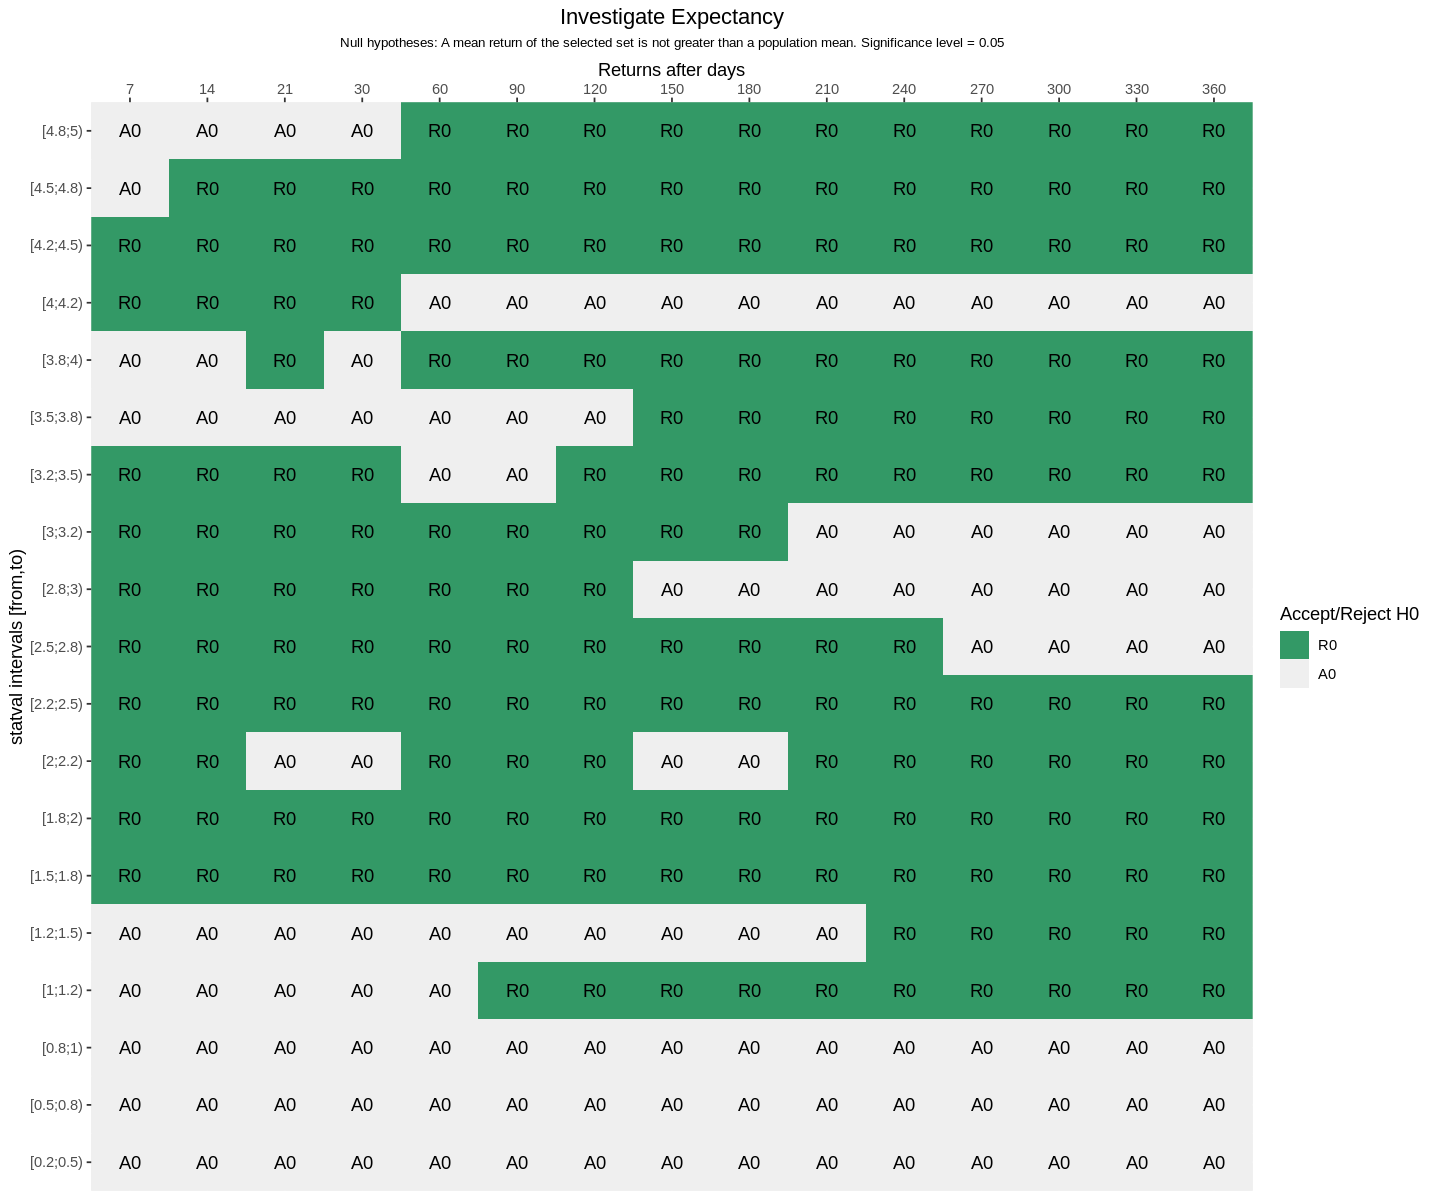

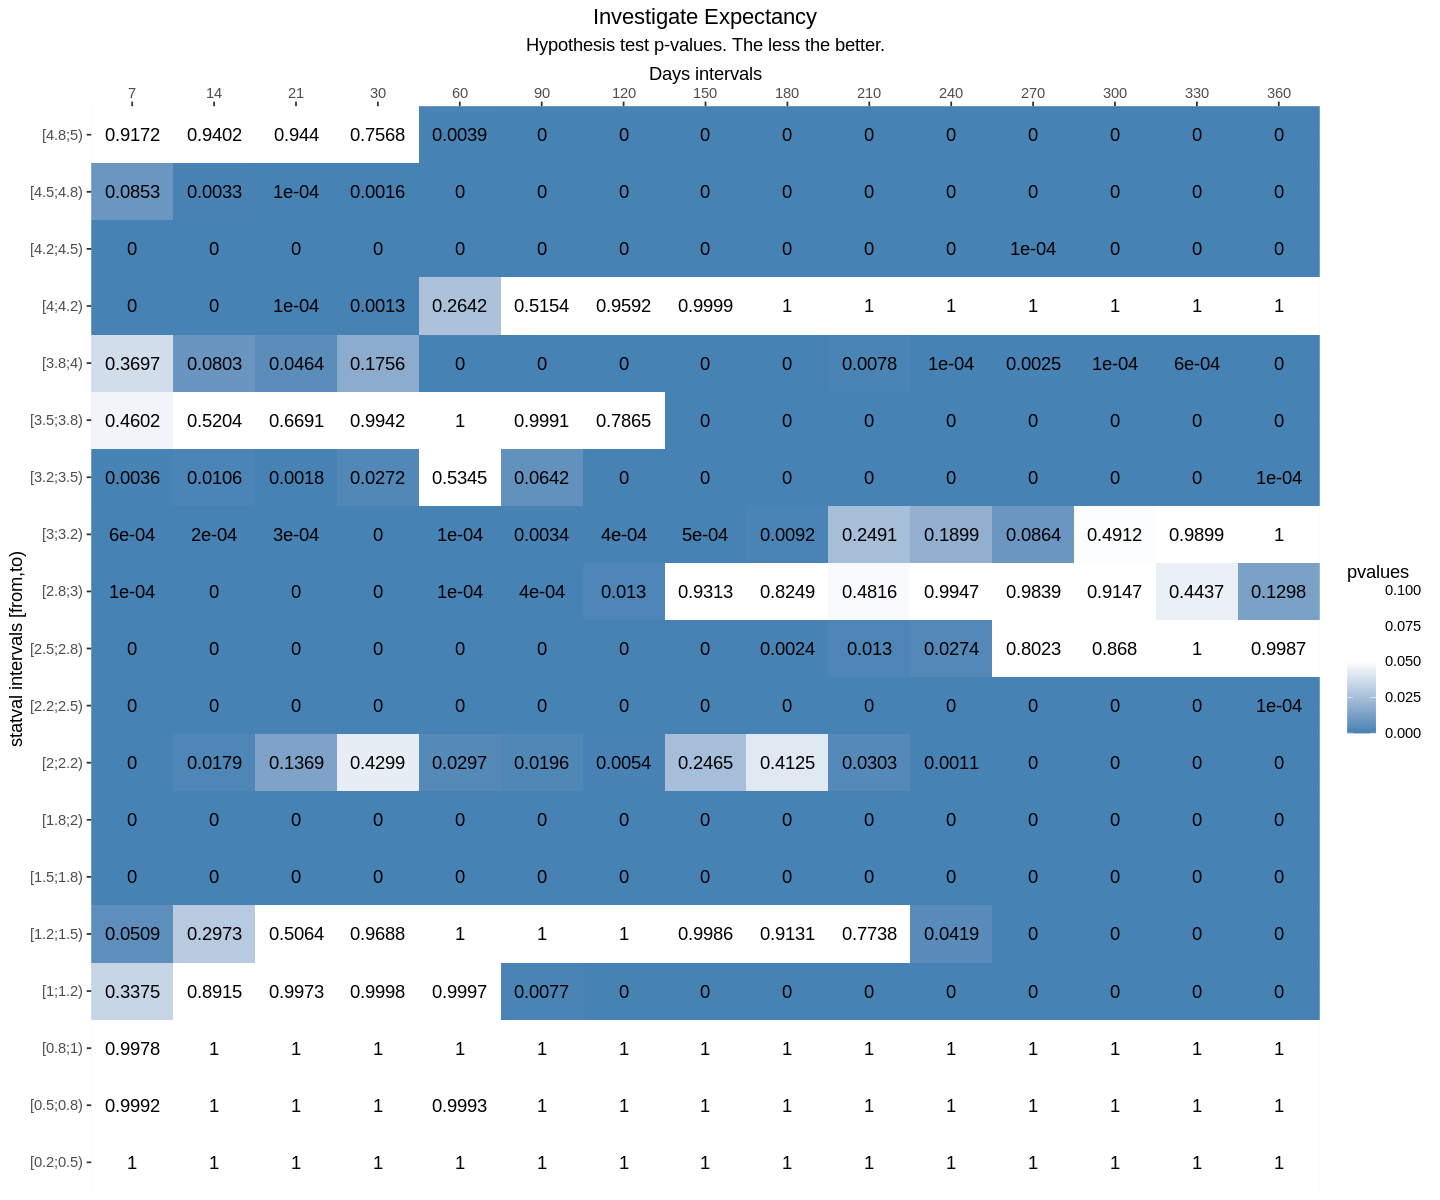

In [11]:
experiment = list(
  name = "Expectancy",
  description = "Investigate Expectancy",
  sqlText = sql, # the latest sql above
  attributeName = "statval",
  attributeSteps = seq(from = 0.25, to = 5.0, by = 0.25))

result = makeExperiment(experiment)


Hypothesis test of sample standard deviation.

Alternative hypothesis: The sample standard deviation is less than the population SD.


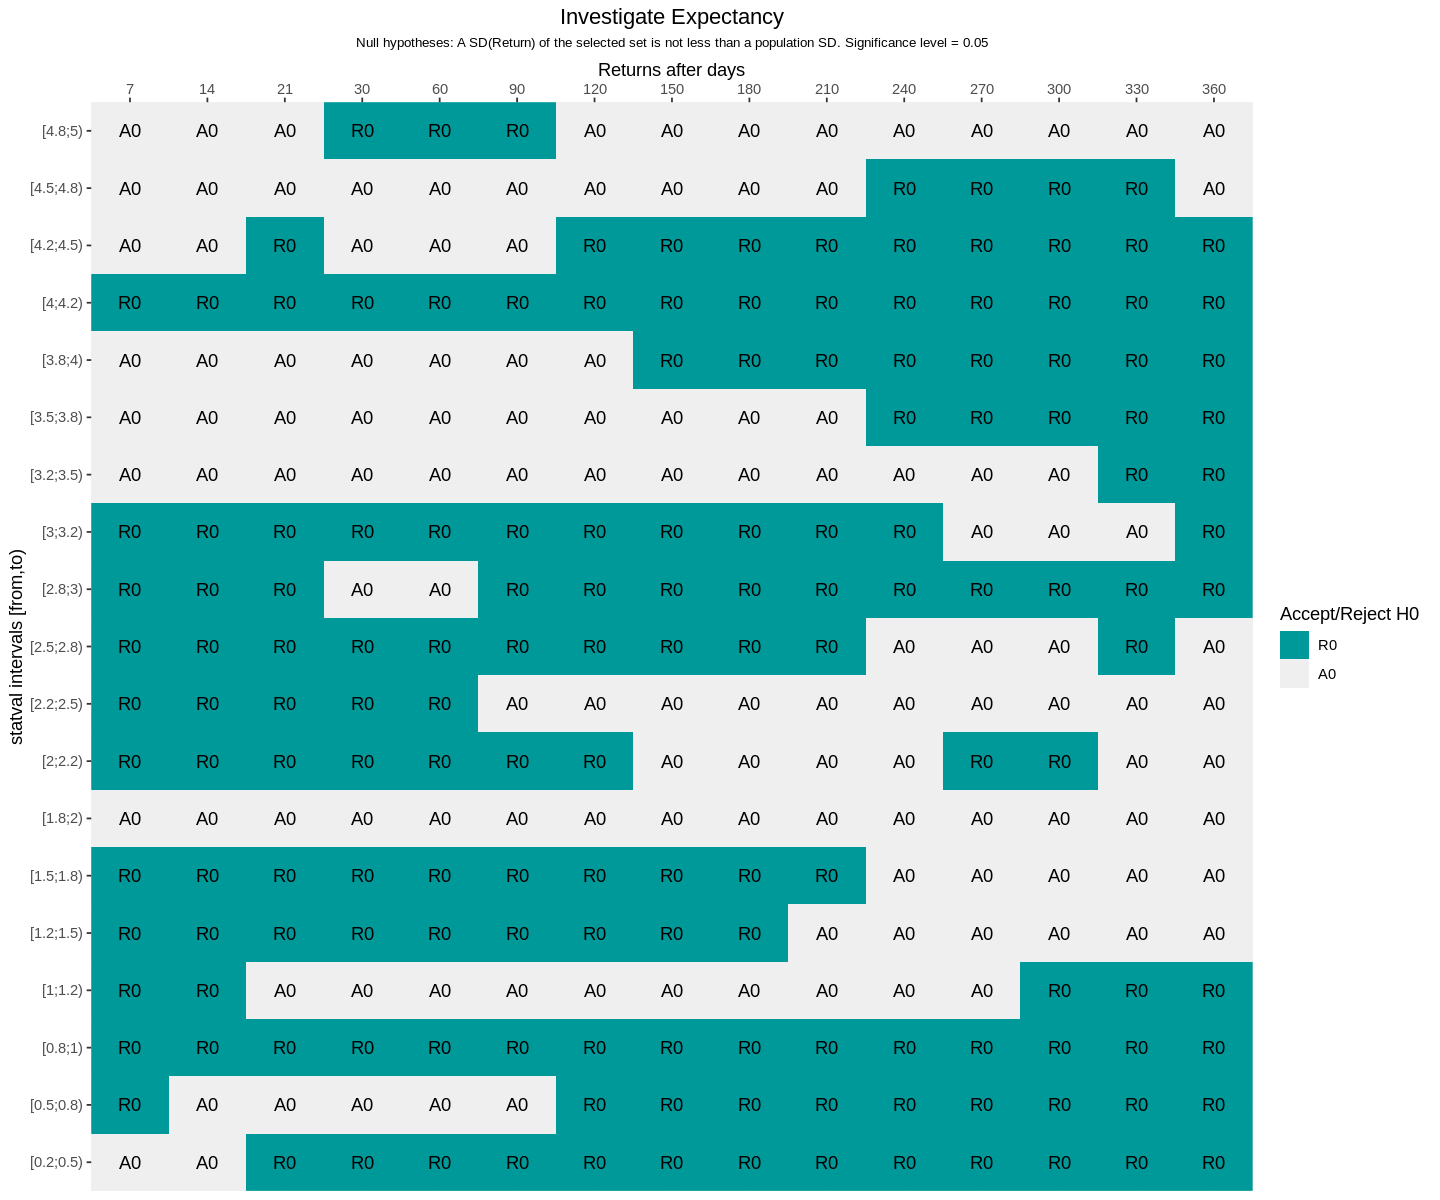

In [12]:
showSDLessHypothesisTest(experiment, result)

In [13]:
showObservationsCounts(experiment, result)


The following table contains numbers of observations in the used statistics intervals.
A number of observations in the sample is an important part of the hypothesis testing. Be careful if it is low (less than 30).
Numbers of observations shown in this table are NOT numbers of C2 strategies! Every strategy can have many observations in any statistics interval. That is what is shown here.


Selection,Obs007,Obs014,Obs021,Obs030,Obs060,Obs090,Obs120,Obs150,Obs180,Obs210,Obs240,Obs270,Obs300,Obs330,Obs360
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4.75 <= statval < 5,1445,1419,1390,1353,1260,1085,883,771,706,612,574,541,527,480,439
4.5 <= statval < 4.75,1762,1743,1710,1672,1561,1487,1312,1125,1017,915,822,731,621,520,436
4.25 <= statval < 4.5,2292,2242,2206,2163,2086,1927,1741,1548,1420,1304,1195,1089,1010,915,818
4 <= statval < 4.25,3688,3636,3588,3518,3351,3125,2933,2781,2515,2248,2079,1934,1805,1709,1613
3.75 <= statval < 4,2701,2641,2592,2533,2281,2061,1800,1590,1473,1379,1275,1190,1079,969,878
3.5 <= statval < 3.75,2949,2870,2797,2708,2308,1913,1619,1439,1224,1064,967,870,723,629,581
3.25 <= statval < 3.5,3937,3856,3784,3716,3272,2773,2410,2106,1895,1600,1378,1201,1046,949,821
3 <= statval < 3.25,6705,6618,6519,6355,5821,5193,4541,3967,3451,3086,2720,2433,2252,2064,1865
2.75 <= statval < 3,7747,7613,7448,7193,6389,5631,5000,4477,3906,3444,3089,2747,2435,2081,1805



SampleMetricValue minus PopulationMetricValue

This table shows differences between metric values calculated for the whole population and the current sample metric values. (See the chapter 'Population statistics'.)
This is different from our hypothesis test. Our hypothesis test tests an (alternative) hypothesis 'Is a mean of the sample greater than a mean of the population?'
But our metric is 'Mean divided by SD'. So the standard deviation plays a role in it.
Our metric is greater when a numerator is greater and/or denominator is less. It is up to you what you prefer.



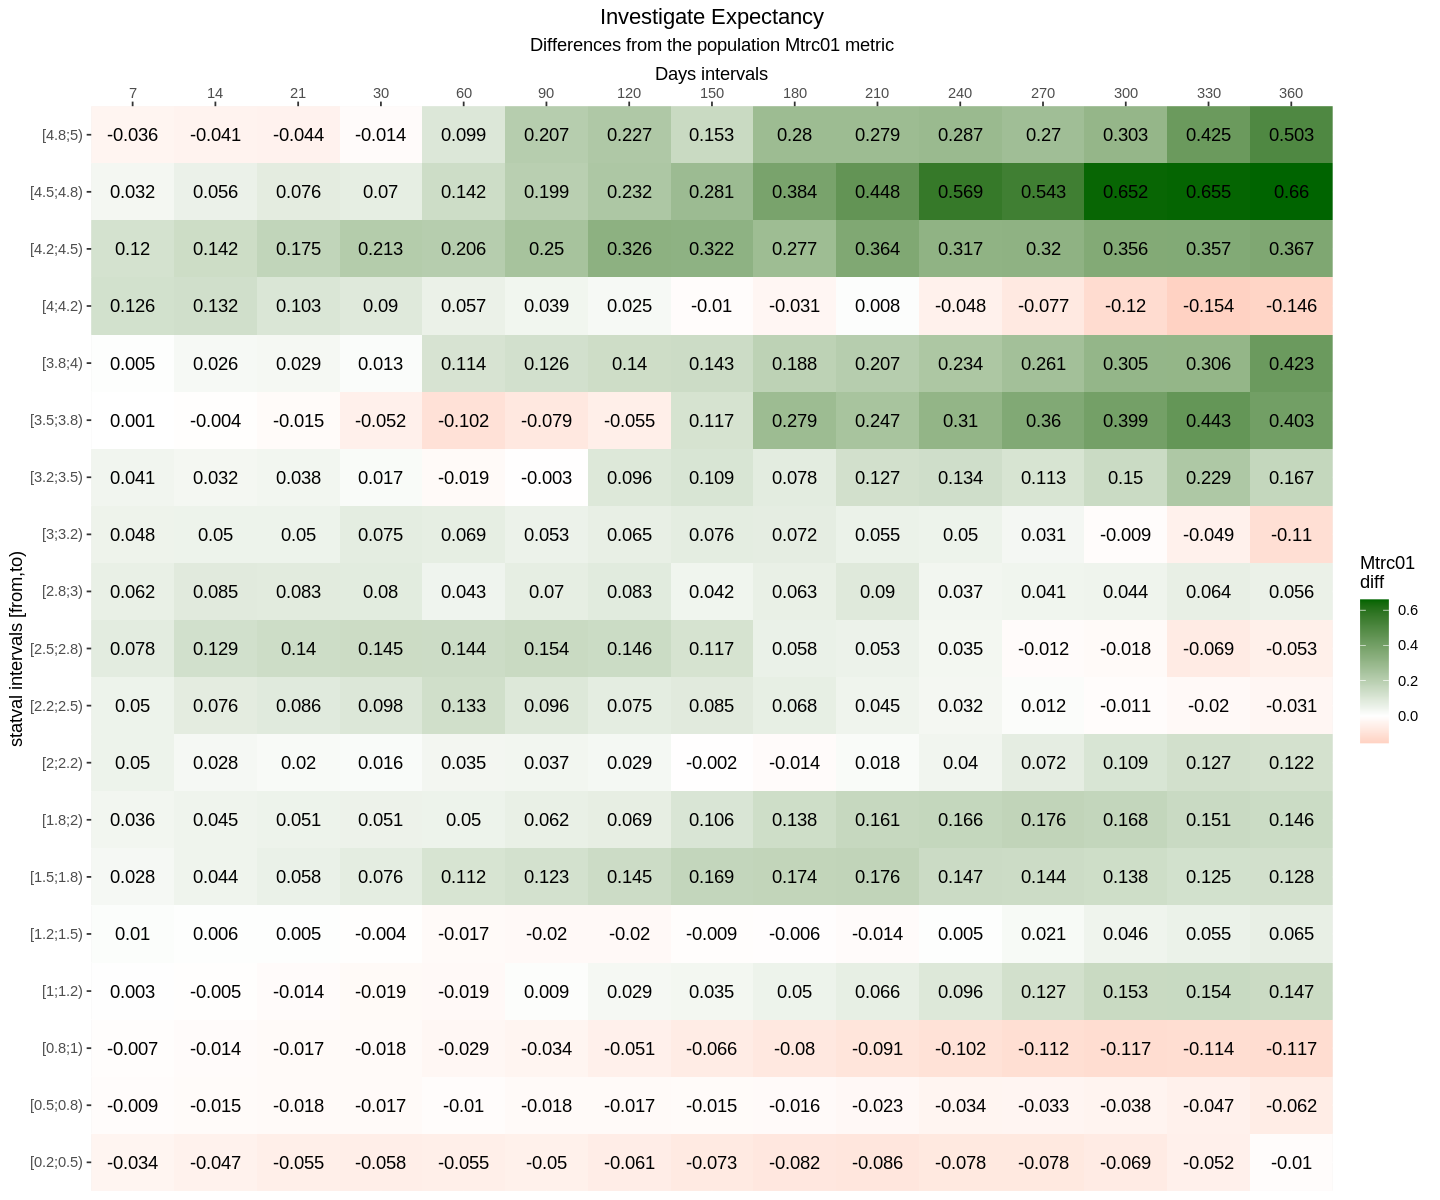

In [14]:
showMetricDifferences(experiment, result)

In [15]:
showSystemsCounts(experiment, result)



Numbers of strategies observed in defined intervals.

Selection,Sys007,Sys014,Sys021,Sys030,Sys060,Sys090,Sys120,Sys150,Sys180,Sys210,Sys240,Sys270,Sys300,Sys330,Sys360
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4.75 <= statval < 5,105,102,98,96,88,80,72,62,51,44,39,36,35,29,26
4.5 <= statval < 4.75,126,124,122,122,114,104,86,69,63,55,50,45,43,36,33
4.25 <= statval < 4.5,138,136,135,135,126,115,96,85,75,66,60,51,48,40,35
4 <= statval < 4.25,173,169,164,161,148,134,111,101,84,70,60,55,50,43,38
3.75 <= statval < 4,171,165,158,155,146,129,114,98,88,78,70,65,60,51,44
3.5 <= statval < 3.75,211,206,202,201,186,165,138,122,103,87,82,72,64,55,51
3.25 <= statval < 3.5,250,245,242,237,226,193,160,141,122,107,92,83,77,64,57
3 <= statval < 3.25,273,272,270,266,252,214,179,152,134,120,110,103,95,81,75
2.75 <= statval < 3,304,303,298,290,273,235,195,170,150,129,115,101,88,78,64


### Discussion
 
This is one of the best attributes. Values above 1.5 makes results better almost everywhere.